## **Avni Singh**

## **22070126023**

## **AIML-A1**

## **Objective:**
The goal of this assignment is to implement a Deep Convolutional Generative Adversarial Network (DCGAN) as described in the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" by Radford et al. (2015).



Importing dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os


# Loading data from kaggle

In [ ]:
# Download CELEBA dataset from Kaggle
os.makedirs("./data/celeba", exist_ok=True)
!kaggle datasets download -d jessicali9530/celeba-dataset -p ./data/celeba --unzip

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:09<00:00, 157MB/s]
100% 1.33G/1.33G [00:09<00:00, 153MB/s]


In [ ]:
# Set random seed for reproducibility
manualSeed = 999
torch.manual_seed(manualSeed)

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
# Hyperparameters for the Deep Convolutional Generative Adversarial Network (DCGAN)
batch_size = 128     # Number of images processed in each training iteration
image_size = 64      # Standardized image dimensions
nz = 100             # Size of the latent space (random noise vector)
ngf = 64             # Number of generator feature maps
ndf = 64             # Number of discriminator feature maps
num_epochs = 25      # Total training iterations
lr = 0.0002          # Learning rate for optimization
beta1 = 0.5          # Exponential decay rate for first moment in Adam optimizer

In [ ]:
# Data preprocessing pipeline to prepare images for training
transform = transforms.Compose([
    transforms.Resize(image_size),               # Resize images to standard size
    transforms.CenterCrop(image_size),           # Crop images from center
    transforms.ToTensor(),                       # Convert to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize pixel values to [-1, 1]
])

# Load the CelebA dataset using ImageFolder with defined transformations
dataset = dsets.ImageFolder(root="./data/celeba", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Weight initialization function for neural network layers
def weights_init(m):
    classname = m.__class__.__name__
    # Initialize convolutional layers with normal distribution
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    # Initialize batch normalization layers
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Network: Converts random noise to images
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Sequential layer for generating images from noise
        self.main = nn.Sequential(
            # Transposed convolutions to gradually upsample noise to image
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Output activation to constrain pixel values
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Discriminator Network: Classifies images as real or fake
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Sequential layer for classifying images
        self.main = nn.Sequential(
            # Convolutional layers to downsample and extract features
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output probability of image being real
        )

    def forward(self, input):
        return self.main(input)



In [ ]:
# Initialize generator and discriminator networks
netG = Generator().to(device)
netD = Discriminator().to(device)
# Apply custom weight initialization
netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
# Loss function (Binary Cross Entropy) and Optimizers
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training parameters
real_label = 1.0  # Label for real images
fake_label = 0.0  # Label for fake images
# Generate fixed noise for consistent image generation during training
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
g_losses, d_losses = [], []  # Track generator and discriminator losses

Epoch [0/25] Step [0/1583] LossD: 1.5546 LossG: 5.6176
Epoch [0/25] Step [100/1583] LossD: 0.9105 LossG: 12.9426
Epoch [0/25] Step [200/1583] LossD: 0.4029 LossG: 3.1946
Epoch [0/25] Step [300/1583] LossD: 0.4669 LossG: 3.9941
Epoch [0/25] Step [400/1583] LossD: 0.5628 LossG: 5.1451
Epoch [0/25] Step [500/1583] LossD: 1.5111 LossG: 2.9228
Epoch [0/25] Step [600/1583] LossD: 0.4106 LossG: 4.0527
Epoch [0/25] Step [700/1583] LossD: 0.3992 LossG: 4.8267
Epoch [0/25] Step [800/1583] LossD: 0.5192 LossG: 5.1687
Epoch [0/25] Step [900/1583] LossD: 0.3684 LossG: 3.8516
Epoch [0/25] Step [1000/1583] LossD: 0.7556 LossG: 6.2470
Epoch [0/25] Step [1100/1583] LossD: 0.9825 LossG: 6.9699
Epoch [0/25] Step [1200/1583] LossD: 0.2717 LossG: 4.8837
Epoch [0/25] Step [1300/1583] LossD: 0.7241 LossG: 3.0205
Epoch [0/25] Step [1400/1583] LossD: 0.3369 LossG: 4.3910
Epoch [0/25] Step [1500/1583] LossD: 0.5461 LossG: 4.7929
Epoch [1/25] Step [0/1583] LossD: 0.6360 LossG: 5.6156
Epoch [1/25] Step [100/1583]

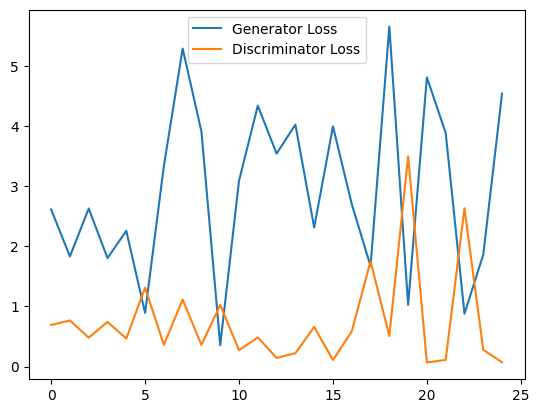

In [ ]:
# Main training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)

        # Train Discriminator on real images
        netD.zero_grad()
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, torch.full_like(output, real_label, device=device))
        lossD_real.backward()

        # Train Discriminator on fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, torch.full_like(output, fake_label, device=device))
        lossD_fake.backward()
        optimizerD.step()

        # Train Generator to fool Discriminator
        netG.zero_grad()
        output = netD(fake_images).view(-1)
        lossG = criterion(output, torch.full_like(output, real_label, device=device))
        lossG.backward()
        optimizerG.step()

        # Print training progress
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Step [{i}/{len(dataloader)}] LossD: {lossD_real.item() + lossD_fake.item():.4f} LossG: {lossG.item():.4f}")

    # Store losses for each epoch
    g_losses.append(lossG.item())
    d_losses.append(lossD_real.item() + lossD_fake.item())

    # Create output directory
    os.makedirs("output", exist_ok=True)

    # Generate and save images using fixed noise
    with torch.no_grad():
      fake_images = netG(fixed_noise).cpu()
    vutils.save_image(fake_images, f"output/fake_epoch_{epoch}.png", normalize=True)

# Plot training losses
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.legend()
plt.show()


In [ ]:
# Create directory for saving models
os.makedirs("./models", exist_ok=True)

# Save generator and discriminator
torch.save(netG.state_dict(), "./models/generator.pth")
torch.save(netD.state_dict(), "./models/discriminator.pth")
print("Models saved successfully!")

Models saved successfully!


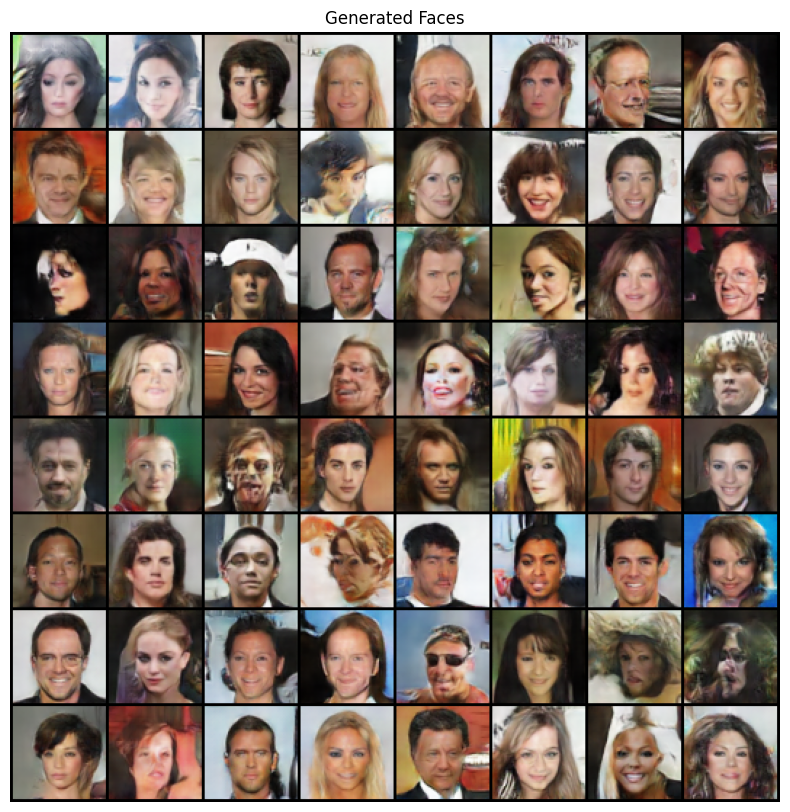

In [ ]:
# Load and display generated images from the last epoch
from PIL import Image

img = Image.open("output/fake_epoch_24.png")  # Replace 24 with your last epoch
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title("Generated Faces")
plt.show()